In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.fft import fftn, ifftn, fftfreq,fft
#from spectral_derivative import  calc_deriv_fftn_with_ext#,calc_deriv_in_frequency_space
import os
import pynumdiff

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

2023-10-20 15:08:40,656 [INFO] 
Limited Total Variation Regularization Support Detected! 
---> CVXPY is not installed. 
---> Many Total Variation Methods require CVXPY including: 
---> velocity, acceleration, jerk, jerk_sliding, smooth_acceleration
---> Please install CVXPY to use these methods.
---> Recommended to also install MOSEK and obtain a MOSEK license.
You can still use: total_variation_regularization.iterative_velocity

2023-10-20 15:08:40,668 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2023-10-20 15:08:40,674 [INFO] 
Limited Linear Model Support Detected! 
---> CVXPY is not installed. 
---> Install CVXPY to use lineardiff derivatives 
You can still use other methods 



In [2]:
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise,normalise_frobenius,normalise_minmax
def compute_distance_svs(u,dx,fd_orders=range(2,8),normalise=None):
    distance_svs = []
    for fd_order in fd_orders:
        ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                             drop_endpoints=False)._differentiate(u, dx)
    
        u_flat, u_x_flat = u.flatten(), ux.flatten()
        features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
        if normalise!=None:
            features = normalise(features)
        svs = svd(features, compute_uv=False)
        distance_svs.append(svs[-1])
    return distance_svs

# Exponential function: $u(t,x)=exp(x+at)$

In [3]:
experiment_name = "linear_nonunique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_nonunique_1
exp(1.7497654730547*t + x)


Noise level: 0
No normalisation: matrix rank = 1, svd = [7.68523628e+06 1.02195314e-05]
Frobenius normalisation: matrix rank = 1, svd = [1.0000000e+00 1.3297574e-12]
Minmax normalisation: matrix rank = 1, svd = [8.21518536e+00 1.09243131e-11]
Noise level: 1e-10
No normalisation: matrix rank = 2, svd = [7.68523629e+06 4.71703806e-02]
Frobenius normalisation: matrix rank = 2, svd = [1.00000000e+00 6.13779186e-09]
Minmax normalisation: matrix rank = 2, svd = [8.21518535e+00 5.04230977e-08]
Noise level: 1e-09
No normalisation: matrix rank = 2, svd = [7.68523630e+06 4.71711847e-01]
Frobenius normalisation: matrix rank = 2, svd = [1.00000000e+00 6.13789647e-08]
Minmax normalisation: matrix rank = 2, svd = [8.21518521e+00 5.04239563e-07]
Noise level: 1e-08
No normalisation: matrix rank = 2, svd = [7.68523645e+06 4.71712641e+00]
Frobenius normalisation: matrix rank = 2, svd = [1.00000000e+00 6.13790668e-07]
Minmax normalisation: matrix rank = 2, svd = [8.21518381e+00 5.04240316e-06]
Noise leve

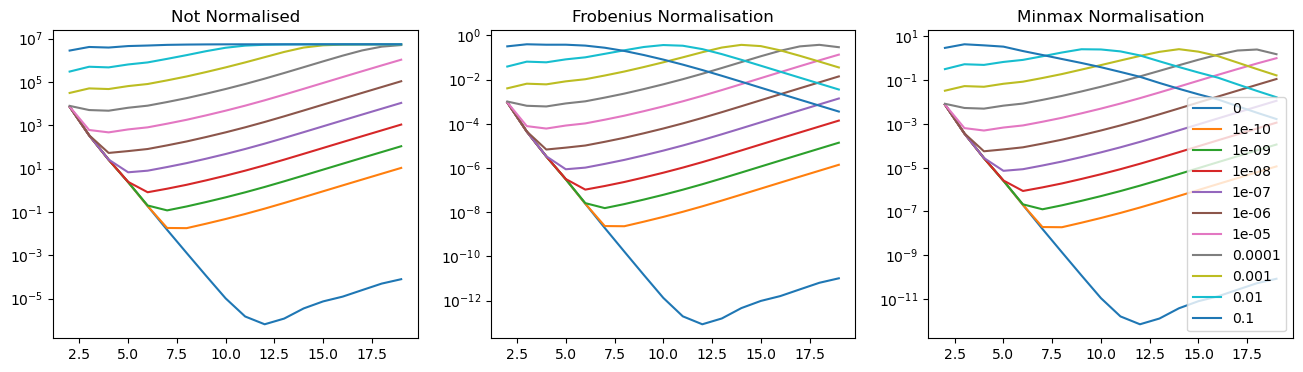

In [4]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Not Normalised")
plt.yscale('log')
plt.subplot(1,3,2)
plt.title("Frobenius Normalisation")
plt.subplot(1,3,3)
plt.title("Minmax Normalisation")
m=20
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    #Calculate normalisation and print rank and svd
    g_noise_frobenius=normalise_frobenius(g_noise)
    g_noise_minmax=normalise_minmax(g_noise)
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    print(f"No normalisation: matrix rank = {matrix_rank(g_noise)}, svd = {svd(g_noise, compute_uv=False)}")
    print(f"Frobenius normalisation: matrix rank = {matrix_rank(g_noise_frobenius)}, svd = {svd(g_noise_frobenius, compute_uv=False)}")
    print(f"Minmax normalisation: matrix rank = {matrix_rank(g_noise_minmax)}, svd = {svd(g_noise_minmax, compute_uv=False)}")
    #Calculate distances and plot
    distance_svs_noise_frobenius = compute_distance_svs(u_noise,dx,fd_orders=range(2,m),normalise=normalise_frobenius)
    distance_svs_noise_minmax = compute_distance_svs(u_noise,dx,fd_orders=range(2,m),normalise=normalise_minmax)
    plt.subplot(1,3,1)
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.subplot(1,3,2)
    plt.plot(range(2,m), distance_svs_noise_frobenius,label=str(target_noise))
    plt.yscale('log')
    plt.subplot(1,3,3)
    plt.plot(range(2,m), distance_svs_noise_minmax,label=str(target_noise))
plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")

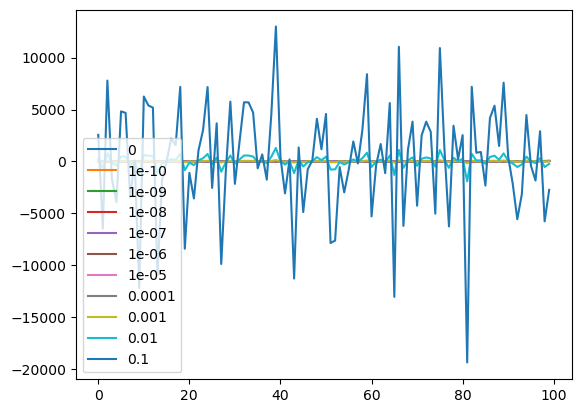

In [5]:
for target_noise in noise_levels:
    u_noise = add_noise(u,target_noise)
    plt.plot(u_noise[0],label=str(target_noise))
plt.legend()
#plt.savefig("noise_levels_func.png")
plt.show()


### Try calculationg the derivative with the Fourier Transform

In [6]:
from spectral_derivative import calc_deriv_fftn_with_ext
ux_fft = calc_deriv_fftn_with_ext(u,[x,t],[0],[dx])

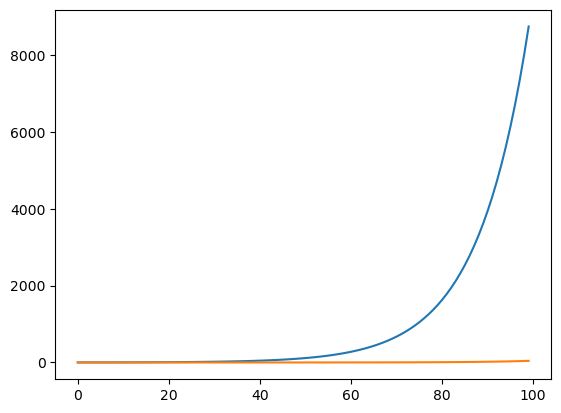

In [7]:
plt.plot(ux_fft[0])
plt.plot(u[0])

In [8]:
from spectral_derivative import calc_deriv_fftn_with_ext
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    #ux_noise = ps.FiniteDifference(order=10, d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    ux_fft = calc_deriv_fftn_with_ext(u_noise,[x,t],[0],[dx])
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_fft.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    print( matrix_rank(g_noise), svd(g_noise, compute_uv=False))


Noise level: 0
2 [7671646.28316754   78682.02570464]
Noise level: 1e-10
2 [7671646.28313487   78682.02572825]
Noise level: 1e-09
2 [7671646.2828408   78682.0259408]
Noise level: 1e-08
2 [7671646.27990013   78682.02806895]
Noise level: 1e-07
2 [7671646.25049606   78682.04961501]
Noise level: 1e-06
2 [7671645.95672492   78682.29152689]
Noise level: 1e-05
2 [7671643.04596391   78687.35565157]
Noise level: 0.0001
2 [7671616.63338101   79001.86974318]
Noise level: 0.001
2 [7671622.00813879  104402.95639894]
Noise level: 0.01
2 [7698781.28201477  686029.81530159]
Noise level: 0.1
2 [11404959.052428    4627967.43443212]


# Exponential function: $u(t,x)=(bt+x)exp(at)$

In [9]:
experiment_name = "linear_unique_1"
u,x,t,formula = experiment_data(n_samples=100,experiment_name=experiment_name)
print(experiment_name)
print(formula)
dx=x[1]-x[0]
dt=t[1]-t[0]

linear_unique_1
(0.326723884469505*t + x)*exp(0.741146843060084*t)


Noise level: 0
No normalisation: matrix rank = 2, svd = [4971.40654551 1348.56946974]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180375]
Minmax normalisation: matrix rank = 2, svd = [18.42251024  4.99738548]
Noise level: 1e-10
No normalisation: matrix rank = 2, svd = [4971.40654562 1348.56947038]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180375]
Minmax normalisation: matrix rank = 2, svd = [18.42251025  4.99738548]
Noise level: 1e-09
No normalisation: matrix rank = 2, svd = [4971.40654661 1348.56947619]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180375]
Minmax normalisation: matrix rank = 2, svd = [18.42251025  4.9973855 ]
Noise level: 1e-08
No normalisation: matrix rank = 2, svd = [4971.40655648 1348.56953423]
Frobenius normalisation: matrix rank = 2, svd = [0.96512113 0.26180376]
Minmax normalisation: matrix rank = 2, svd = [18.42251029  4.99738572]
Noise level: 1e-07
No normalisation: matrix rank = 2, svd = [4971.406655

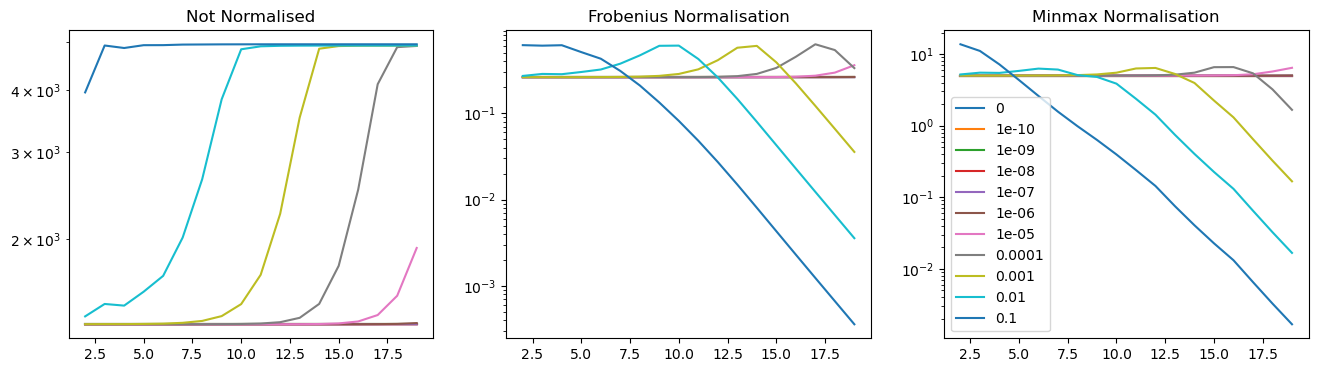

In [11]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("Not Normalised")
plt.yscale('log')
plt.subplot(1,3,2)
plt.title("Frobenius Normalisation")
plt.subplot(1,3,3)
plt.title("Minmax Normalisation")
m=20
for target_noise in noise_levels:
    print(f"Noise level: {target_noise}")
    u_noise = add_noise(u,target_noise)
    ux_noise = ps.FiniteDifference(order=10,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    #Calculate normalisation and print rank and svd
    g_noise_frobenius=normalise_frobenius(g_noise)
    g_noise_minmax=normalise_minmax(g_noise)
    distance_svs_noise = compute_distance_svs(u_noise,dx,fd_orders=range(2,m))
    print(f"No normalisation: matrix rank = {matrix_rank(g_noise)}, svd = {svd(g_noise, compute_uv=False)}")
    print(f"Frobenius normalisation: matrix rank = {matrix_rank(g_noise_frobenius)}, svd = {svd(g_noise_frobenius, compute_uv=False)}")
    print(f"Minmax normalisation: matrix rank = {matrix_rank(g_noise_minmax)}, svd = {svd(g_noise_minmax, compute_uv=False)}")
    #Calculate distances and plot
    distance_svs_noise_frobenius = compute_distance_svs(u_noise,dx,fd_orders=range(2,m),normalise=normalise_frobenius)
    distance_svs_noise_minmax = compute_distance_svs(u_noise,dx,fd_orders=range(2,m),normalise=normalise_minmax)
    plt.subplot(1,3,1)
    plt.plot(range(2,m), distance_svs_noise,label=str(target_noise))
    plt.subplot(1,3,2)
    plt.plot(range(2,m), distance_svs_noise_frobenius,label=str(target_noise))
    plt.yscale('log')
    plt.subplot(1,3,3)
    plt.plot(range(2,m), distance_svs_noise_minmax,label=str(target_noise))
plt.yscale('log')
plt.legend()
plt.savefig("noise_levels")